# <center>Optimization In Security Trading</center>
#### <center> Max Van Puyvelde </sub></center>

### <font color='lightblue'>Table of contents<font><a class='anchor' id='top'></a>
- [Part 1: Portfolio Optimization](#part-1-portfolio-optimization)
    - [A. Monte Carlo & Efficient Frontier](#a-monte-carlo--efficient-frontier)
    - [B. Objective functions](##B.-Objective-functions)
        - [1. SLSQP](###1.-SLSQP-(Sequential-Least-Squares-Programming))
        - [2. L-BFGS-B](###2.-L-BFGS-B)
        - [3. CVXPY - ECOS solver](###3.-CVXPY-ECOS)
- [Part 2: Optimal Order Execution](#Part-2:-Optimal-Order-Execution)
    - [A. CVXPY](##A.-CVXPY)
    - [B. Genetic Algorithm](##B.-Genetic-Algorithm)
- [Part 3: Option pricing](#Part-3:-Option-pricing)
    - [A. BFGS](####A.-BFGS)
    - [B. Nelder-Mead](####B.-Nelder-Mead)
    - [C. Conjugate Gradient](##C.-Conjugate-Gradient)
    - [D. SLSQP](##D.-SLSQP)
    - [E. Visualizations](##E.-Visualizations)
- [Part 4. Hedging Simulated Annealing](##Part-4.-Hedging-Simulated-Annealing)

## Part 1: Portfolio optimization

Building on the principles of Modern Portfolio Theory, this optimization project aims to maximize the Sharpe Ratio, a measure of risk-adjusted return, to determine the optimal portfolio composition. By leveraging optimization algorithms, the project will systematically adjust the weights of various assets in the portfolio to find the combination that offers the highest expected return for a given level of risk, thereby providing an efficient tool for investment decision-making.

In [ ]:
# Imports

import cvxpy as cp
import yfinance as yf
import pandas as pd
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns

In [2]:
# To get a list of tickers, we will scrape the Wikipedia page that contains the list of S&P 500 companies.

def scrape_tickers():
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text.strip()
        tickers.append(ticker)

    return tickers

sp500_tickers = scrape_tickers()
sp500_tickers.count('')

0

No empty tickers.

In [3]:
# Download the stock data
data = yf.download(sp500_tickers, start='2020-03-31', end='2024-03-31')

# For this purpose, only the close prices are needed.
prices = data['Adj Close']

[*********************100%%**********************]  503 of 503 completed

4 Failed downloads:
['GEV', 'SOLV']: Exception("%ticker%: Data doesn't exist for startDate = 1585627200, endDate = 1711857600")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2020-03-31 -> 2024-03-31)')


In [4]:
# Drop the columns (tickers) where NA values are found
prices_clean = prices.dropna(axis=1)
prices_clean.isna().sum()

Ticker
A       0
AAL     0
AAPL    0
ABBV    0
ABT     0
       ..
XYL     0
YUM     0
ZBH     0
ZBRA    0
ZTS     0
Length: 494, dtype: int64

In [5]:
# Calculate the returns of the stocks
returns = prices_clean.pct_change().dropna() # dropna to drop the first line with NA values (no return on the first day)

In [6]:
returns.head()

Ticker,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-01,-0.037699,-0.123052,-0.052617,-0.036357,-0.029654,-0.085734,-0.052554,-0.053513,-0.062019,-0.037237,...,-0.080424,-0.048967,-0.102841,-0.036816,-0.011588,-0.082297,-0.012841,-0.113277,-0.038889,-0.049027
2020-04-02,0.048897,-0.058934,0.016687,0.023291,0.037482,0.011530,0.010280,0.009130,0.042930,0.013581,...,0.014214,-0.017370,-0.024630,0.040289,0.076472,0.060733,-0.023651,0.034364,-0.012581,0.036723
2020-04-03,-0.025868,-0.066600,-0.014371,-0.023426,0.000126,-0.064970,-0.026365,-0.034051,-0.012999,0.009321,...,-0.008333,-0.031566,-0.079172,-0.042370,-0.029455,-0.045741,-0.041635,-0.007551,0.022039,-0.012238
2020-04-06,0.055950,0.011715,0.087238,0.032166,0.041284,0.098334,0.091357,0.086918,0.106747,0.032612,...,0.116303,0.114733,0.169691,0.056862,0.032135,0.077521,0.113744,0.064449,0.077325,0.106273
2020-04-07,-0.004438,0.075790,-0.011583,-0.004490,-0.009670,0.031446,-0.011623,-0.031962,0.004697,0.005590,...,0.018990,0.011111,0.072625,-0.031398,0.019027,0.015340,0.012057,0.040535,0.002658,-0.005363


In [7]:
# Create a function to calculate the portfolio's overall annualized returns and annualized volatility
def calculate_portfolio_performance(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    return portfolio_return, portfolio_volatility

# Create a function to generate random weights for each stock in the portfolio
def generate_random_weights(number_of_stocks):
    weights = np.random.random(number_of_stocks)
    weights /= np.sum(weights)
    return weights

## A. Monte Carlo & Efficient Frontier

Monte Carlo simulation is a powerful technique for portfolio optimization, leveraging randomness to model and analyze the behavior of asset returns. By simulating thousands of potential future scenarios, it allows us to assess the probabilistic distribution of portfolio returns and risks. The portfolios generated through these simulations are evaluated based on the Sharpe ratio, which measures the excess return per unit of risk, calculated as the portfolio's return (minus the risk-free rate), divided by the portfolio's standard deviation.

Higher Sharpe ratios indicate more efficient portfolios. After evaluating the Sharpe ratios, the efficient frontier is plotted, representing the set of optimal portfolios offering the highest expected return for a given level of risk. Inspecting the efficient frontier helps in visualizing the trade-off between risk and return, guiding investors in selecting the most suitable asset allocation.

The Sharpe ratio is defined as:

$S(w) = Rp / σp$

Where:

- $S(w)$ is the Sharpe Ratio
- $Rp$ is the portfolio return
- $σp$ is the portfolio standard deviation
- $w$ is the vector of portfolio weights

<center>
<img src="sharpe.png" width=200>
<p>William Sharpe</p>
</center>

In [8]:
# Get the stock names
stock_names = prices_clean.columns

# Run a Monte Carlo simulation to generate a large number of random portfolios
number_of_portfolios = 10000
number_of_stocks = len(stock_names)

# Initialize a list to store the portfolio data
portfolios = []

for _ in range(number_of_portfolios):
    weights = generate_random_weights(number_of_stocks)
    portfolio_return, portfolio_volatility = calculate_portfolio_performance(weights, returns)
    
    # Create a dictionary to store the data for this portfolio
    portfolio_data = {'return': portfolio_return, 'volatility': portfolio_volatility}
    
    # Add the weights to the dictionary
    for i in range(number_of_stocks):
        portfolio_data[stock_names[i]] = weights[i]
    
    # Append the dictionary to the list
    portfolios.append(portfolio_data)

In [9]:
# Convert the list of dictionaries to a DataFrame
portfolios = pd.DataFrame(portfolios)

# Calculate the Sharpe Ratios for the portfolios
portfolios['sharpe_ratio'] = portfolios['return'] / portfolios['volatility']

# Find the portfolio with the highest Sharpe Ratio
max_sharpe_ratio_index = portfolios['sharpe_ratio'].idxmax()

In [10]:
portfolios['sharpe_ratio'].iloc[max_sharpe_ratio_index]

1.3494017298701846

A Sharpe Ratio of 1.35 is generally considered good, however this can be improved by optimization methods.

In [11]:
# A quick look at the portfolios
portfolios.head()

,return,volatility,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,...,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS,sharpe_ratio
0,0.244561,0.196152,0.000820,0.000945,0.000630,0.004042,0.001614,0.000707,0.000201,0.000339,...,0.000127,0.002405,0.000879,0.001929,0.002560,0.004194,0.003892,0.001984,0.003801,1.246790
1,0.250186,0.195070,0.003707,0.000742,0.003753,0.002827,0.003972,0.003084,0.002057,0.003119,...,0.001330,0.000244,0.000396,0.002250,0.003786,0.000262,0.002963,0.001927,0.003326,1.282545
2,0.248950,0.198490,0.000239,0.001727,0.001702,0.000758,0.002169,0.003372,0.002289,0.002475,...,0.003681,0.000689,0.002122,0.002252,0.001283,0.002993,0.000201,0.000072,0.000335,1.254221
3,0.249005,0.195123,0.001719,0.003496,0.003903,0.001407,0.003331,0.002636,0.001088,0.002425,...,0.001707,0.002338,0.003657,0.000675,0.001536,0.001439,0.003103,0.001164,0.003284,1.276141
4,0.249062,0.197341,0.003587,0.001225,0.000951,0.001580,0.000017,0.002794,0.002461,0.001242,...,0.002482,0.001556,0.000106,0.000660,0.000933,0.000141,0.003130,0.003648,0.001150,1.262087


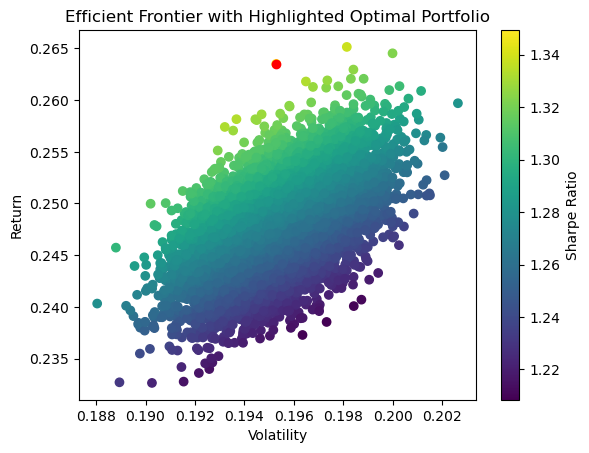

In [12]:
# Plot the simulated portfolios
plt.scatter(portfolios['volatility'], portfolios['return'], c=portfolios['sharpe_ratio'], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# Highlight the portfolio with the highest Sharpe Ratio
plt.scatter(portfolios.loc[max_sharpe_ratio_index, 'volatility'], portfolios.loc[max_sharpe_ratio_index, 'return'], color='r')
plt.title('Efficient Frontier with Highlighted Optimal Portfolio')

plt.show()

The plotted efficient frontier visually represents the set of optimal portfolios that offer the highest expected return for a given level of risk. The highlighted point on this frontier signifies the optimal portfolio with the maximum Sharpe Ratio. This portfolio provides the best risk-adjusted return, making it an ideal choice for investors seeking to maximize their returns while efficiently managing risk.

As an investor you seek the largest return for the smallest volatility, the portfolios in the top left corner are considered good options.

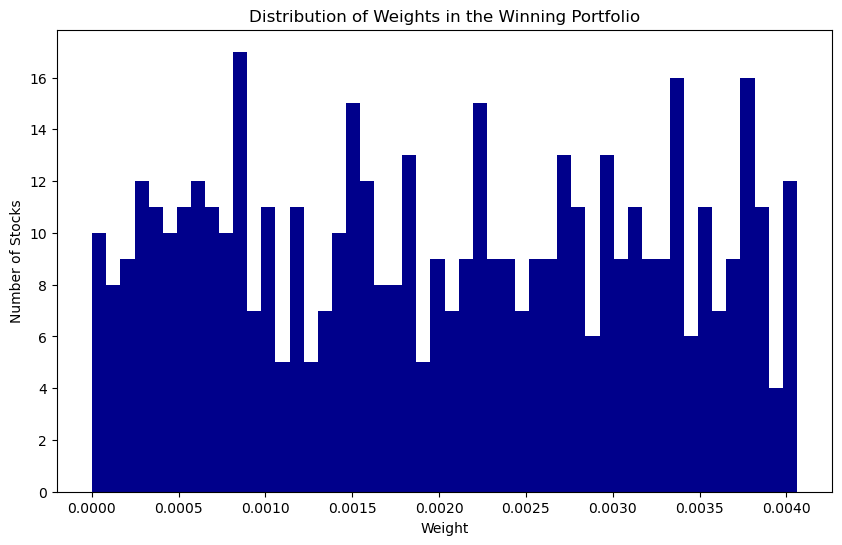

In [13]:
# Find the portfolio with the highest return
winning_portfolio = portfolios.iloc[max_sharpe_ratio_index]

# Remove the 'return' and 'volatility' entries
winning_weights = winning_portfolio.drop(['return', 'volatility','sharpe_ratio'])

winning_weights.hist(bins=50, figsize=(10, 6),grid=False, color='darkblue')
plt.title('Distribution of Weights in the Winning Portfolio')
plt.xlabel('Weight')
plt.ylabel('Number of Stocks')
plt.show()

As an investor, portfolio diversification is important as a high concentration in a single stock can lead to high risk. This distribution of weights shows that the winning portfolio is well-diversified, with no single stock having a disproportionately high weight.

## B. Objective functions

### 1. SLSQP (Sequential Least Squares Programming)

Sequential Least Squares Programming (SLSQP) is an optimization algorithm used to solve constrained optimization problems.

The SLSQP algorithm works by iteratively approximating the solution using a **quadratic approximation** of the objective function and the constraints. It starts with an initial guess for the values of the variables and then iteratively updates them until convergence is achieved.

During each iteration, SLSQP solves a quadratic programming subproblem to find the search direction and step size for updating the variables. It takes into account the gradients and Hessians of the objective function and the constraints to guide the search.

The objective function is the Sharpe Ratio: $S(w) = Rp / σp$

Subject to constraints:

$∑wi = 1$, for all i in {1, 2, ..., n}

$0 ≤ wi ≤ 1$, for all i in {1, 2, ..., n}

Where:

- $S(w)$ is the Sharpe Ratio
- $Rp$ is the portfolio return
- $σp$ is the portfolio standard deviation
- w is the vector of portfolio weights
- n is the number of stocks in the portfolio

In [40]:
# Calculate returns from price data
returns = prices_clean.pct_change().dropna()


# Define the objective function (negative Sharpe Ratio)
def objective(weights):
    portfolio_return = np.sum(returns.mean() * weights) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility
    return -sharpe_ratio  # We negate because we want to maximize the Sharpe Ratio

# Define the constraints (weights must sum to 1)
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

number_of_stocks= prices_clean.shape[1]

# Define the bounds (weights must be between 0 and 1 because we wont short)
bounds = tuple((0, 1) for _ in range(number_of_stocks))

# Initial guess for the weights (equal distribution)
init_guess = np.array(number_of_stocks * [1. / number_of_stocks,])

# Run the optimizer
result = minimize(objective, init_guess, method='SLSQP', bounds=bounds, constraints=constraints, options={'ftol': 1e-06})

# The optimal weights are in result.x
optimal_weights = result.x

print(optimal_weights[0:20])

[7.89023881e-15 3.74714728e-15 2.27294004e-14 7.19003569e-02
 1.41006357e-14 2.82618838e-14 1.37941768e-15 1.53236691e-15
 6.43499206e-16 1.62668549e-14 6.94626320e-15 1.54779788e-15
 8.59376512e-15 1.56838519e-14 1.74758487e-15 2.09006468e-14
 4.25591412e-15 1.70117714e-14 4.52804560e-14 8.52797552e-15]


In [15]:
print("The sharpe ratio is {}".format(-result.fun))

The sharpe ratio is 2.8745701544319613


A sharpe ratio of 2.87 is a very good result and already a big improvement from the optimal portfolio obtained from monte carlo simulations.

### 2. L-BFGS-B

The BFGS (Broyden-Fletcher-Goldfarb-Shanno) method is an optimization algorithm used to solve unconstrained optimization problems. It belongs to the class of quasi-Newton methods, which aim to find the minimum of a function without explicitly computing its derivatives.

The BFGS method approximates the Hessian matrix of the objective function using a series of rank-one updates. The Hessian matrix represents the second-order derivatives of the objective function and provides information about the curvature of the function's surface. By iteratively updating the approximation of the Hessian matrix, the BFGS method converges towards the minimum of the function.

The BFGS method is known for its good convergence properties and is widely used in optimization problems. It combines the benefits of gradient-based methods (which use first-order derivatives) and Newton's method (which uses second-order derivatives) by approximating the Hessian matrix without explicitly computing it.

The L-BFGS-B variant is a limited-memory version of the BFGS method that is specifically designed for solving optimization problems with bound constraints. The "L" in L-BFGS-B stands for "limited-memory," which means that it stores a limited number of past iterations to approximate the Hessian matrix.

The L-BFGS-B variant is particularly useful when dealing with large-scale optimization problems where the Hessian matrix is too expensive to compute or store. It uses a limited-memory approach to approximate the Hessian matrix efficiently, making it suitable for problems with a large number of variables.

In addition to the BFGS updates, the L-BFGS-B variant also incorporates bound constraints into the optimization process. Bound constraints restrict the values of the variables within a specified range. The L-BFGS-B method ensures that the optimization process respects these constraints and finds the optimal solution within the given bounds.

Maximize: $S(w) = Rp / σp$

Subject to:

$0 ≤ wi ≤ 1$, for all i in {1, 2, ..., n}

Where:

- $S(w)$ is the Sharpe Ratio
- $Rp$ is the portfolio return
- $σp$ is the portfolio standard deviation
- w is the vector of portfolio weights
- n is the number of stocks in the portfolio

In [39]:
# Calculate returns from price data
returns = prices_clean.pct_change().dropna()


# Define the objective function (negative Sharpe Ratio)
def objective(weights):
    portfolio_return = np.sum(returns.mean() * weights) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility
    return -sharpe_ratio  # We negate because we want to maximize the Sharpe Ratio

number_of_stocks= prices_clean.shape[1]

# Define the bounds (weights must be between 0 and 1 because we wont short)
bounds = tuple((0, 1) for _ in range(number_of_stocks))

# Initial guess for the weights (equal distribution)
init_guess = np.array(number_of_stocks * [1. / number_of_stocks,])

# Run the optimizer
result = minimize(objective, init_guess, method='L-BFGS-B', bounds=bounds, options={'ftol': 1e-06})

# The optimal weights are in result.x
optimal_weights = result.x

# Normalize the weights so they sum to 1 since this method does not support constraints
optimal_weights = optimal_weights / np.sum(optimal_weights)
print(optimal_weights[0:20])

[0.         0.         0.00362506 0.01051982 0.         0.00520306
 0.         0.         0.         0.00030022 0.         0.
 0.         0.         0.         0.00224791 0.00238827 0.00023901
 0.00710379 0.        ]


In [17]:
print("The sharpe ratio is {}".format(-result.fun))

The sharpe ratio is 2.0733293478002843


This result is an improvement from the Monte Carlo simulations but worse than the L-BFGS-B method.

### 3. CVXPY ECOS

The ECOS solver is an optimization solver that is commonly used for solving convex optimization problems. It stands for Embedded Conic Solver and is based on the second-order cone programming (SOCP) framework.

The ECOS solver utilizes the conic programming approach, which allows it to handle a wide range of convex optimization problems efficiently. It can handle linear constraints, second-order cone constraints, and exponential cone constraints.

The algorithm used by ECOS is an interior-point method, specifically a primal-dual interior-point method. This method iteratively solves a sequence of barrier subproblems, which are optimization problems with a logarithmic barrier term added to the objective function. The barrier term ensures that the iterates stay within the feasible region.

At each iteration, the solver computes search directions for the primal and dual variables, updates the iterates, and checks for convergence. The process continues until a stopping criterion is met, such as reaching a desired level of accuracy or the maximum number of iterations.

Here we dont optimize the Sharpe Ratio directly but we maximize the returns while setting a target volatility as boundary.

Maximize: $Rp(w) = ∑wi * ri$

Constraints:

- $∑wi = 1$, for all i in {1, 2, ..., n}
- $0 ≤ wi ≤ 1$, for all i in {1, 2, ..., n}
- $σp(w)$ ≤ target_volatility

Where:

- $Rp(w)$ is the portfolio return
- $ri$ is the return of stock i
- $σp(w)$ is the portfolio standard deviation
- $w$ is the vector of portfolio weights
- n is the number of stocks in the portfolio
- target_volatility is the desired portfolio volatility

In [ ]:
target_volatility= 0.15


# Define the weights variable
weights = cp.Variable(number_of_stocks)

# Define the objective function
portfolio_return = np.array(returns.mean()) * weights * 252
portfolio_volatility = cp.quad_form(weights, returns.cov() * 252)

# Define the constraints
constraints = [cp.sum(weights) == 1, 
               weights >= 0, 
               weights <= 1, 
               portfolio_volatility <= target_volatility**2]  # Add a constraint on the portfolio volatility

# Define the problem and solve it using the ECOS solver
problem = cp.Problem(cp.Maximize(portfolio_return), constraints)
problem.solve(solver=cp.ECOS)

# The optimal weights are in weights.value
optimal_weights = weights.value

# Calculate the portfolio return and volatility with the optimal weights
optimal_return = np.sum(returns.mean() * optimal_weights) * 252
optimal_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(returns.cov() * 252, optimal_weights)))

# Calculate the Sharpe ratio
sharpe_ratio = optimal_return / optimal_volatility

In [19]:
print("The sharpe ratio is {}".format(sharpe_ratio))

The sharpe ratio is 2.7333379706620247


This Sharpe Ratio is better than the one we obtained by the Monte Carlo simulations and the L-BFGS-B but still slightly worse than the SLSQP method.

<u>The end result is:</u>

| Rank | Method      | Sharpe Ratio |
|------|-------------|-------|
| 1    | SLSQP       | 2.87  |
| 2    | ECOS        | 2.73  |
| 3    | L-BFGS-B    | 2.07  |
| 4    | Monte Carlo | 1.35  |

## Part 2: Optimal Order Execution

We want to minimize the market disturbance caused by our trades. We'll model the disturbance at each tick as the price impact of our trades, which is the product of the trade size and the difference between the ask volume-weighted average price (VWAP) and bid VWAP. This is a model that aims to limit the price impact of our trades.

Our objective function is then:

Minimize: $∑ (I_i)^2$ for all i from 1 to N

- $I_i$ as the price impact at tick i caused by our trade.
- $T_i$ as the volume of trades at tick i.
- $O$ as the total order size.
- N as the number of ticks

Our constraints are:

- The total volume of trades must equal the order size: $∑ T_i = O$ for all i from 1 to N
- Each trade must be non-negative: $T_i ≥ 0$ for all i from 1 to N

We then solve this optimization problem to find the optimal trade sizes that minimize the total price impact. We also compare the performance of this strategy with a simple strategy that sells an equal number of shares at each tick. The performance is evaluated based on the total cost, which is the sum of the price impacts of all trades.

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class OrderBookSimulator:
    def __init__(self):
        self.order_book = pd.DataFrame({
            'bid_price': np.arange(90, 100, dtype=float)[::-1],
            'bid_size': np.random.randint(1, 10, 10),
            'ask_price': np.arange(101, 111, dtype=float),
            'ask_size': np.random.randint(1, 10, 10)
        })
        self.order_book_history = []

    def update_order_book(self):
        # Randomly update the sizes
        self.order_book['bid_size'] = np.random.randint(1, 10, 10)
        self.order_book['ask_size'] = np.random.randint(1, 10, 10)

        # If the lowest ask price = the highest bid price + 1
        if self.order_book['ask_price'].min() == self.order_book['bid_price'].max() + 2:
            # The bid side may only move with -1
            if np.random.rand() < 0.1:
                self.order_book['bid_price'] -= 1
            # The ask side may only move with 1
            if np.random.rand() < 0.1:
                self.order_book['ask_price'] += 1
        else:
            if np.random.rand() < 0.5:
                if np.random.rand() < 0.5:
                    self.order_book['bid_price'] -= 1
                else:
                    self.order_book['bid_price'] += 1
            else:
                if np.random.rand() < 0.5:
                    self.order_book['ask_price'] -= 1
                else:
                    self.order_book['ask_price'] += 1
        # Add the current state of the order book to the history
        self.order_book_history.append(self.order_book.copy())

In [21]:
# Run the simulation for 1000 ticks
simulator = OrderBookSimulator()
ticks = 100
for _ in range(ticks):
    simulator.update_order_book()

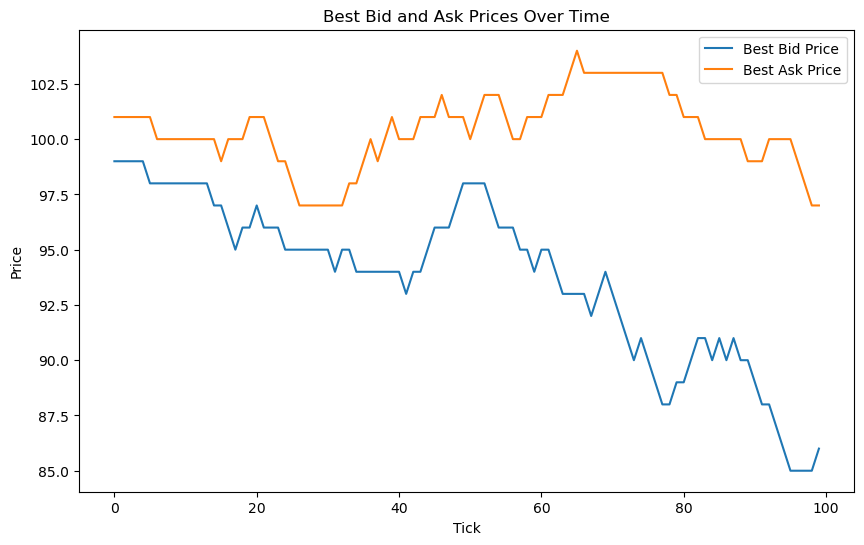

In [22]:
# Visualisation
# Extract the best bid and ask prices at each tick
best_bid_prices = [df['bid_price'].max() for df in simulator.order_book_history]
best_ask_prices = [df['ask_price'].min() for df in simulator.order_book_history]

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(range(ticks), best_bid_prices, label='Best Bid Price')
plt.plot(range(ticks), best_ask_prices, label='Best Ask Price')
plt.xlabel('Tick')
plt.ylabel('Price')
plt.title('Best Bid and Ask Prices Over Time')
plt.legend()
plt.show()

In this model, the price impact of a trade is calculated as the absolute value of the product of the trade size and the difference between the ask VWAP and bid VWAP. This means that for a given price difference, a smaller trade size will result in a smaller price impact.

The intuition behind this is that in a market with a larger spread between the bid and ask prices (which is reflected in a larger difference between the ask VWAP and bid VWAP), each trade has a larger potential to move the market price. This is because the market is less liquid, so a given amount of trading volume has a larger effect on the price.

By making smaller trades when the price difference is large, a trader can reduce the price impact of their trades, which can help to minimize the cost of trading. This is the strategy that the model is trying to implement by minimizing the sum of squares of the price impacts.

However, this is a simplified model and doesn't take into account many factors that could affect the price impact of trades in a real-world market, such as the depth of the market beyond the top level and the reaction of other market participants to the trades.

## A. CVXPY

In [23]:
import cvxpy as cp

class OptimalExecution:
    def __init__(self, simulator, total_shares):
        self.simulator = simulator
        self.total_shares = total_shares

    def run(self):
        # Number of ticks
        n = len(self.simulator.order_book_history)

        # Trade sizes
        x = cp.Variable(n)

        # Price impacts
        impacts = []
        for i in range(n):
            order_book = self.simulator.order_book_history[i]
            bid_vwap = (order_book['bid_price'] * order_book['bid_size']).sum() / order_book['bid_size'].sum()
            ask_vwap = (order_book['ask_price'] * order_book['ask_size']).sum() / order_book['ask_size'].sum()
            impact = cp.abs(x[i]) * (ask_vwap - bid_vwap)
            impacts.append(impact)

        # Objective function
        objective = cp.Minimize(cp.sum_squares(cp.hstack(impacts)))
        

        # Constraints
        constraints = [cp.sum(x) == self.total_shares]

        # Problem
        problem = cp.Problem(objective, constraints)

        # Solve the problem
        problem.solve()

        return x.value
    
    def evaluate(self, trade_sizes):
        # Number of ticks
        n = len(self.simulator.order_book_history)
    
        # Price impacts and prices
        impacts = []
        prices = []
        for i in range(n):
            order_book = self.simulator.order_book_history[i]
            bid_vwap = (order_book['bid_price'] * order_book['bid_size']).sum() / order_book['bid_size'].sum()
            ask_vwap = (order_book['ask_price'] * order_book['ask_size']).sum() / order_book['ask_size'].sum()
            impact = abs(trade_sizes[i]) * (ask_vwap - bid_vwap)
            impacts.append(impact)
            prices.append((ask_vwap + bid_vwap) / 2)  # Use the midpoint of the VWAPs as the trade price
    
        # Total cost
        total_cost = np.sum(np.array(impacts))
    
        # Variance of trade sizes
        variance_of_trade_sizes = np.var(trade_sizes)
    
    
        print(f"Total cost: {total_cost}")
        print(f"Variance of trade sizes: {variance_of_trade_sizes}")

    def evaluate_even_strategy(self):
        # Number of ticks
        n = len(self.simulator.order_book_history)
    
        # Trade size for the even strategy
        even_trade_size = self.total_shares / n
    
        # Price impacts
        impacts = []
        for i in range(n):
            order_book = self.simulator.order_book_history[i]
            bid_vwap = (order_book['bid_price'] * order_book['bid_size']).sum() / order_book['bid_size'].sum()
            ask_vwap = (order_book['ask_price'] * order_book['ask_size']).sum() / order_book['ask_size'].sum()
            impact = even_trade_size * (ask_vwap - bid_vwap)
            impacts.append(impact)
    
        # Total cost
        total_cost = np.sum(np.array(impacts))
    
        print(f"Total cost of even strategy: {total_cost}")

strategy = OptimalExecution(simulator, 1000)
trade_sizes = strategy.run()
strategy.evaluate(trade_sizes)
strategy.evaluate_even_strategy()

Total cost: 13790.95264546293
Variance of trade sizes: 22.56031194127273
Total cost of even strategy: 15580.555444668962


## B. Genetic Algorithm

In [24]:
# Genetic algo

from deap import base, creator, tools
import random

class OptimalExecutionGA:
    def __init__(self, simulator, total_shares):
        self.simulator = simulator
        self.total_shares = total_shares

    def evaluate(self, individual):
        # Calculate the total cost of the trades
        total_cost = 0
        for i, trade_size in enumerate(individual):
            order_book = self.simulator.order_book_history[i]
            bid_vwap = (order_book['bid_price'] * order_book['bid_size']).sum() / order_book['bid_size'].sum()
            ask_vwap = (order_book['ask_price'] * order_book['ask_size']).sum() / order_book['ask_size'].sum()
            impact = abs(trade_size) * (ask_vwap - bid_vwap)
            total_cost += impact
        return total_cost,

    def run(self):
        # Number of ticks
        n = len(self.simulator.order_book_history)

        # Create the fitness and individual classes
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMin)

        # Create the toolbox
        toolbox = base.Toolbox()

        # Register the attribute, individual and population functions
        toolbox.register("attr_float", random.uniform, 0, self.total_shares)
        toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)

        # Register the evaluation, selection, crossover and mutation operators
        toolbox.register("evaluate", self.evaluate)
        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)
        toolbox.register("select", tools.selTournament, tournsize=3)

        # Create the initial population
        pop = toolbox.population(n=50)

        # Run the genetic algorithm
        for gen in range(100):
            offspring = toolbox.select(pop, len(pop))
            offspring = list(map(toolbox.clone, offspring))
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if random.random() < 0.5:
                    toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values
            for mutant in offspring:
                if random.random() < 0.2:
                    toolbox.mutate(mutant)
                    del mutant.fitness.values
            # Normalize the trade sizes so that their sum equals the total number of shares
            for individual in offspring:
                total_trade_size = sum(individual)
                for i in range(len(individual)):
                    individual[i] = individual[i] * self.total_shares / total_trade_size
            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            fitnesses = map(toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit
            pop[:] = offspring

        # Return the trade sizes of the best individual
        best_ind = tools.selBest(pop, 1)[0]
        return best_ind

strategy = OptimalExecutionGA(simulator, 1000)
trade_sizes = strategy.run()
strategy.evaluate(trade_sizes)

(13816.50546906046,)

to do: compare trade sizes

# Part 3: Option pricing

In [25]:
import yfinance as yf
import pandas as pd
import numpy as np
import scipy.stats as si
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import sympy as sp
from scipy.optimize import minimize_scalar

In [26]:
# List of ticker symbols
ticker_symbols = ['TSLA', 'AAPL', 'ARGX', 'EURN']

methods = ['Nelder-Mead', 'CG', 'BFGS', 'SLSQP']

class OptionPricingModel:
    def __init__(self, ticker_symbol, risk_free_rate=0.01):
        self.ticker = yf.Ticker(ticker_symbol)
        self.risk_free_rate = risk_free_rate
    
    def fetch_option_data(self):
        expiration_date = self.ticker.options[0]  # Use the first available expiration date
        options = self.ticker.option_chain(expiration_date)
        self.calls = options.calls
    
    def calculate_time_to_maturity(self):
        expiration_date = self.ticker.options[0]
        self.T = (pd.to_datetime(expiration_date) - pd.Timestamp.today()).days / 365.0
    
    def calculate_spot_price(self):
        self.S = self.ticker.info['regularMarketPreviousClose']
    
    def black_scholes(self, sigma):
        d1 = (np.log(self.S / self.calls['strike']) + (self.risk_free_rate + 0.5 * sigma ** 2) * self.T) / (sigma * np.sqrt(self.T))
        d2 = d1 - sigma * np.sqrt(self.T)
        call_prices = (self.S * si.norm.cdf(d1, 0.0, 1.0) - self.calls['strike'] * np.exp(-self.risk_free_rate * self.T) * si.norm.cdf(d2, 0.0, 1.0))
        call_prices[np.isnan(call_prices)] = -np.inf
        return call_prices

    def optimize_volatility(self, method='Nelder-Mead', sigma_initial=0.5):
        result = minimize(self.objective_function, sigma_initial, method=method)
        self.optimal_sigma = result.x[0]
        print(f"Optimization method: {method}, Optimal sigma: {self.optimal_sigma}, Objective function value: {result.fun}")

    def objective_function(self, sigma):
        model_prices = self.black_scholes(sigma)
        market_prices = self.calls['lastPrice'].values
        return np.sum((model_prices - market_prices) ** 2)

    def compare_prices(self):
        model_prices = self.black_scholes(self.optimal_sigma)
        comparison = pd.DataFrame({
            'Strike Price': self.calls['strike'],
            'Market Price': self.calls['lastPrice'],
            'Model Price': model_prices
        })
        return comparison


def plot_comparisons(comparison_results, models, methods):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs = axs.flatten()
    
    for i, (comparison_result, model, method) in enumerate(zip(comparison_results, models, methods)):
        axs[i].scatter(comparison_result['Strike Price'], comparison_result['Market Price'], label='Market Price', color='blue')
        axs[i].scatter(comparison_result['Strike Price'], comparison_result['Model Price'], label='Model Price', color='red', marker='x')
        axs[i].set_xlabel('Strike Price')
        axs[i].set_ylabel('Option Price')
        axs[i].set_title(f'{method} for {model.ticker.ticker}')
        axs[i].legend()
        axs[i].grid(True)
    
        mae = mean_absolute_error(comparison_result['Market Price'], comparison_result['Model Price'])
        rmse = np.sqrt(mean_squared_error(comparison_result['Market Price'], comparison_result['Model Price']))
        r_squared = r2_score(comparison_result['Market Price'], comparison_result['Model Price'])
    
        axs[i].annotate(f'MAE: {mae:.4f}', xy=(0.45, 0.85), xycoords='axes fraction', fontsize=10, color='blue')
        axs[i].annotate(f'RMSE: {rmse:.4f}', xy=(0.45, 0.80), xycoords='axes fraction', fontsize=10, color='red')
        axs[i].annotate(f'R-squared: {r_squared:.4f}', xy=(0.45, 0.75), xycoords='axes fraction', fontsize=10, color='green')
    
    plt.tight_layout()
    plt.show()


## A. BFGS

In [27]:
# Create empty lists to store comparison results and models
comparison_results = []
models = []
method='BFGS'

# Loop over ticker symbols
for ticker_symbol in ticker_symbols:
    # Create an OptionPricingModel instance for the current ticker
    model = OptionPricingModel(ticker_symbol)
    model.fetch_option_data()
    model.calculate_time_to_maturity()
    model.calculate_spot_price()
    model.optimize_volatility(method=method)
    models.append(model)
    comparison_result = model.compare_prices()
    comparison_results.append(comparison_result)
    

Optimization method: BFGS, Optimal sigma: 0.5095513653290614, Objective function value: 180.8829928499272
Optimization method: BFGS, Optimal sigma: 0.34903511305141866, Objective function value: 115.34744930848323
Optimization method: BFGS, Optimal sigma: 0.9921253089993534, Objective function value: 22807.73434807648
Optimization method: BFGS, Optimal sigma: 1.5805098410063458, Objective function value: 40.78896806021196


## B. Nelder-Mead

In [28]:
# Create empty lists to store comparison results and models
comparison_results = []
models = []
method = 'Nelder-Mead'
# Loop over ticker symbols
for ticker_symbol in ticker_symbols:
    # Create an OptionPricingModel instance for the current ticker
    model = OptionPricingModel(ticker_symbol)
    model.fetch_option_data()
    model.calculate_time_to_maturity()
    model.calculate_spot_price()
    model.optimize_volatility(method=method)
    models.append(model)
    comparison_result = model.compare_prices()
    comparison_results.append(comparison_result)

Optimization method: Nelder-Mead, Optimal sigma: 0.5095703125, Objective function value: 180.8829929931181
Optimization method: Nelder-Mead, Optimal sigma: 0.34902343749999987, Objective function value: 115.34744934529408
Optimization method: Nelder-Mead, Optimal sigma: 0.9920898437500011, Objective function value: 22807.734359833583
Optimization method: Nelder-Mead, Optimal sigma: 1.5804687500000025, Objective function value: 40.788968068540285


## C. Conjugate Gradient

In [29]:
# Create empty lists to store comparison results and models
comparison_results = []
models = []
method = 'CG'
# Loop over ticker symbols
for ticker_symbol in ticker_symbols:
    # Create an OptionPricingModel instance for the current ticker
    model = OptionPricingModel(ticker_symbol)
    model.fetch_option_data()
    model.calculate_time_to_maturity()
    model.calculate_spot_price()
    model.optimize_volatility(method=method)
    models.append(model)
    comparison_result = model.compare_prices()
    comparison_results.append(comparison_result)


Optimization method: CG, Optimal sigma: 0.5095513744443372, Objective function value: 180.8829928499269
Optimization method: CG, Optimal sigma: 0.3490351336217695, Objective function value: 115.34744930848335
Optimization method: CG, Optimal sigma: 0.9921253160732435, Objective function value: 22807.73434807648
Optimization method: CG, Optimal sigma: 1.5805096918379915, Objective function value: 40.788968060211914


## D. SLSQP

In [30]:
# Create empty lists to store comparison results and models
comparison_results = []
models = []
method = 'SLSQP'
# Loop over ticker symbols
for ticker_symbol in ticker_symbols:
    # Create an OptionPricingModel instance for the current ticker
    model = OptionPricingModel(ticker_symbol)
    model.fetch_option_data()
    model.calculate_time_to_maturity()
    model.calculate_spot_price()
    model.optimize_volatility(method=method)
    models.append(model)
    comparison_result = model.compare_prices()
    comparison_results.append(comparison_result)


Optimization method: SLSQP, Optimal sigma: 0.5095606041743056, Objective function value: 180.88299288390292
Optimization method: SLSQP, Optimal sigma: 0.34905528481444, Objective function value: 115.34744941808815
Optimization method: SLSQP, Optimal sigma: 0.9921252427175739, Objective function value: 22807.734348076538
Optimization method: SLSQP, Optimal sigma: 1.5804885993349973, Objective function value: 40.78896806242823


## E. Visualizations

All methods perform nearly identical, showing no obvious winner, here we visualize them

Optimization method: Nelder-Mead, Optimal sigma: 0.5095703125, Objective function value: 180.8829929931181
Optimization method: CG, Optimal sigma: 0.3490351336217695, Objective function value: 115.34744930848335
Optimization method: BFGS, Optimal sigma: 0.9921253089993534, Objective function value: 22807.73434807648
Optimization method: SLSQP, Optimal sigma: 1.5804885993349973, Objective function value: 40.78896806242823


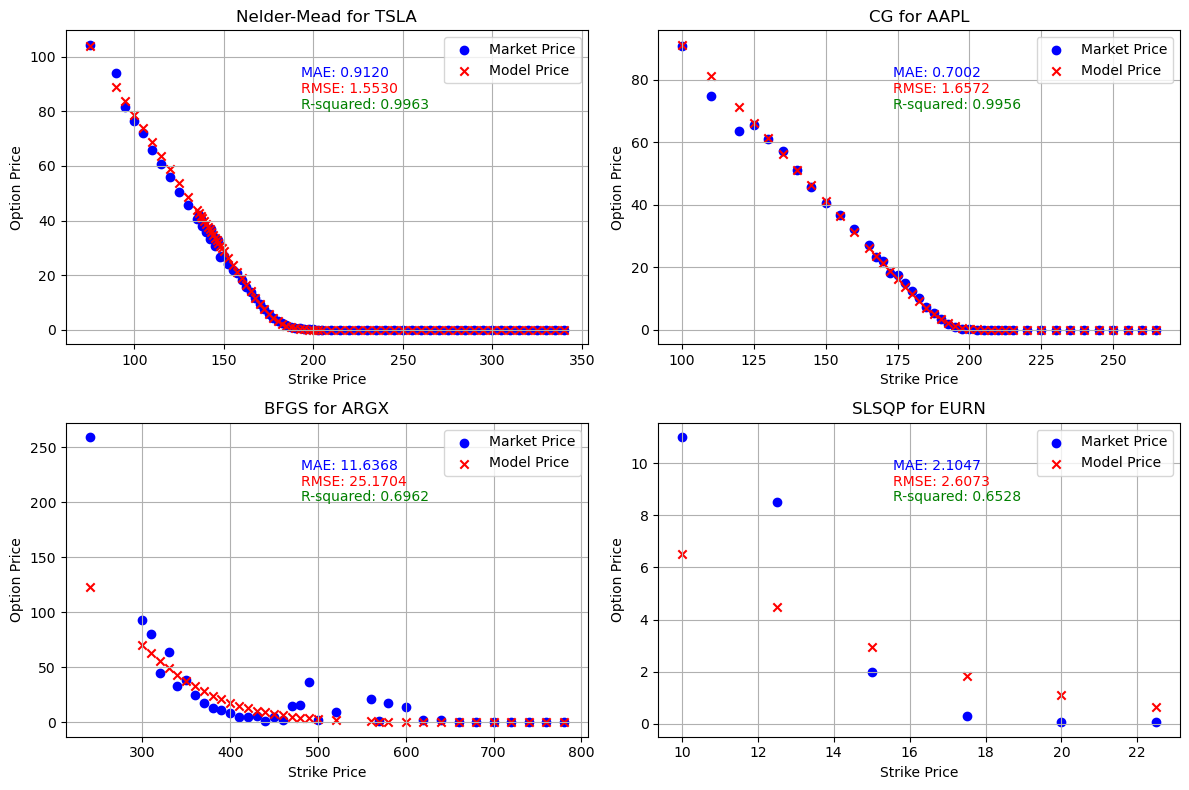

In [31]:
for ticker_symbol, method in zip(ticker_symbols, methods):
    model = OptionPricingModel(ticker_symbol)
    model.fetch_option_data()
    model.calculate_time_to_maturity()
    model.calculate_spot_price()
    model.optimize_volatility(method=method)
    models.append(model)
    comparison_result = model.compare_prices()
    comparison_results.append(comparison_result)

plot_comparisons(comparison_results, models, methods)


# Part 4. Hedging Simulated Annealing

constraint used in simulated annealing: weights add up to 1 (by normalizing the weights in each iteration)

Stocks: The script fetches the adjusted close prices of the stocks for a list of tickers. These prices are used to calculate the value of the portfolio for different weights of the assets. The weights represent the proportion of the portfolio's budget allocated to each asset. The value of the portfolio is calculated as the sum of the product of the stock prices and the weights.

Options: The script fetches the last price and strike price of the first call option for each ticker. These are used to calculate the hedging cost. In this context, options are used as a hedging instrument. Hedging is a strategy used to protect an investment or portfolio against loss. It involves the use of financial instruments, such as options, to offset the risk of any adverse price movements. In this case, the hedging cost is calculated as the sum of the absolute weights times the last price times the strike price of the options.

The objective of the script is to find the weights of the assets in the portfolio that minimize the hedging cost. This is done using the simulated annealing algorithm, which is a probabilistic technique used for finding the global minimum of a function. The algorithm starts with a random solution and iteratively generates new solutions. If the new solution improves the objective function value (i.e., reduces the hedging cost), it is accepted as the current solution. Otherwise, it is accepted with a probability that decreases as the difference between the new and current objective function values increases and as the temperature decreases. The temperature is a parameter of the algorithm that controls the balance between exploration (accepting worse solutions) and exploitation (accepting better solutions). The temperature is gradually decreased during the optimization process, allowing the algorithm to converge to the global minimum.

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import random
import math

def fetch_stock_data(tickers, start_date, end_date):
    stock_data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return stock_data

def fetch_option_data(tickers):
    option_data = []
    successful_tickers = []
    for ticker in tickers:
        try:
            ticker_obj = yf.Ticker(ticker)
            options = ticker_obj.options
            if options:
                data = ticker_obj.option_chain(options[0])
                option_data.append([data.calls['lastPrice'][0], data.calls['strike'][0]])
                successful_tickers.append(ticker)
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
    return np.array(option_data), successful_tickers

def calculate_hedging_cost(weights, stock_data, option_data):
    portfolio_value = np.sum(stock_data * weights, axis=1)
    hedging_cost = np.sum(np.abs(weights) * option_data[:, 0] * option_data[:, 1])
    return hedging_cost / np.mean(portfolio_value)

def simulated_annealing(objective_function, num_dimensions, lb, ub, max_iter=1000, initial_temperature=100, cooling_rate=0.99):
    current_solution = np.random.uniform(lb, ub, num_dimensions)
    current_solution /= np.sum(current_solution)  # Normalize the weights
    current_value = objective_function(current_solution, stock_data, option_data)
    
    best_solution = np.copy(current_solution)
    best_value = current_value
    
    temperature = initial_temperature
    for _ in range(max_iter):
        new_solution = current_solution + np.random.uniform(-0.1, 0.1, num_dimensions)
        new_solution = np.clip(new_solution, lb, ub)
        new_solution /= np.sum(new_solution)  # Normalize the weights
        
        new_value = objective_function(new_solution, stock_data, option_data)
        
        if new_value < current_value or random.random() < math.exp(-(new_value - current_value) / temperature):
            current_solution = np.copy(new_solution)
            current_value = new_value
            
            if new_value < best_value:
                best_solution = np.copy(current_solution)
                best_value = current_value
        
        temperature *= cooling_rate
    
    return best_solution, best_value

# List of S&P 500 tickers
stock_tickers = sp500_tickers

start_date = '2022-01-01'
end_date = '2022-12-31'
stock_data = fetch_stock_data(stock_tickers, start_date, end_date)
option_data, successful_tickers = fetch_option_data(stock_tickers)

# Filter stock_data to only include successful tickers
stock_data = stock_data[successful_tickers]

num_dimensions = len(successful_tickers)
lb = np.zeros(num_dimensions)
ub = np.ones(num_dimensions)

optimal_solution, optimal_value = simulated_annealing(calculate_hedging_cost, num_dimensions, lb, ub)

In [36]:
print("Optimal solution (weights):", optimal_solution[0:20])
print("Optimal value (hedging cost):", optimal_value)

Optimal solution (weights): [0.00100097 0.         0.00753306 0.00445174 0.00179094 0.00042682
 0.         0.         0.         0.         0.00374831 0.00657055
 0.00681328 0.00077676 0.         0.00788162 0.00706372 0.00610973
 0.         0.        ]
Optimal value (hedging cost): 64.2799851072549


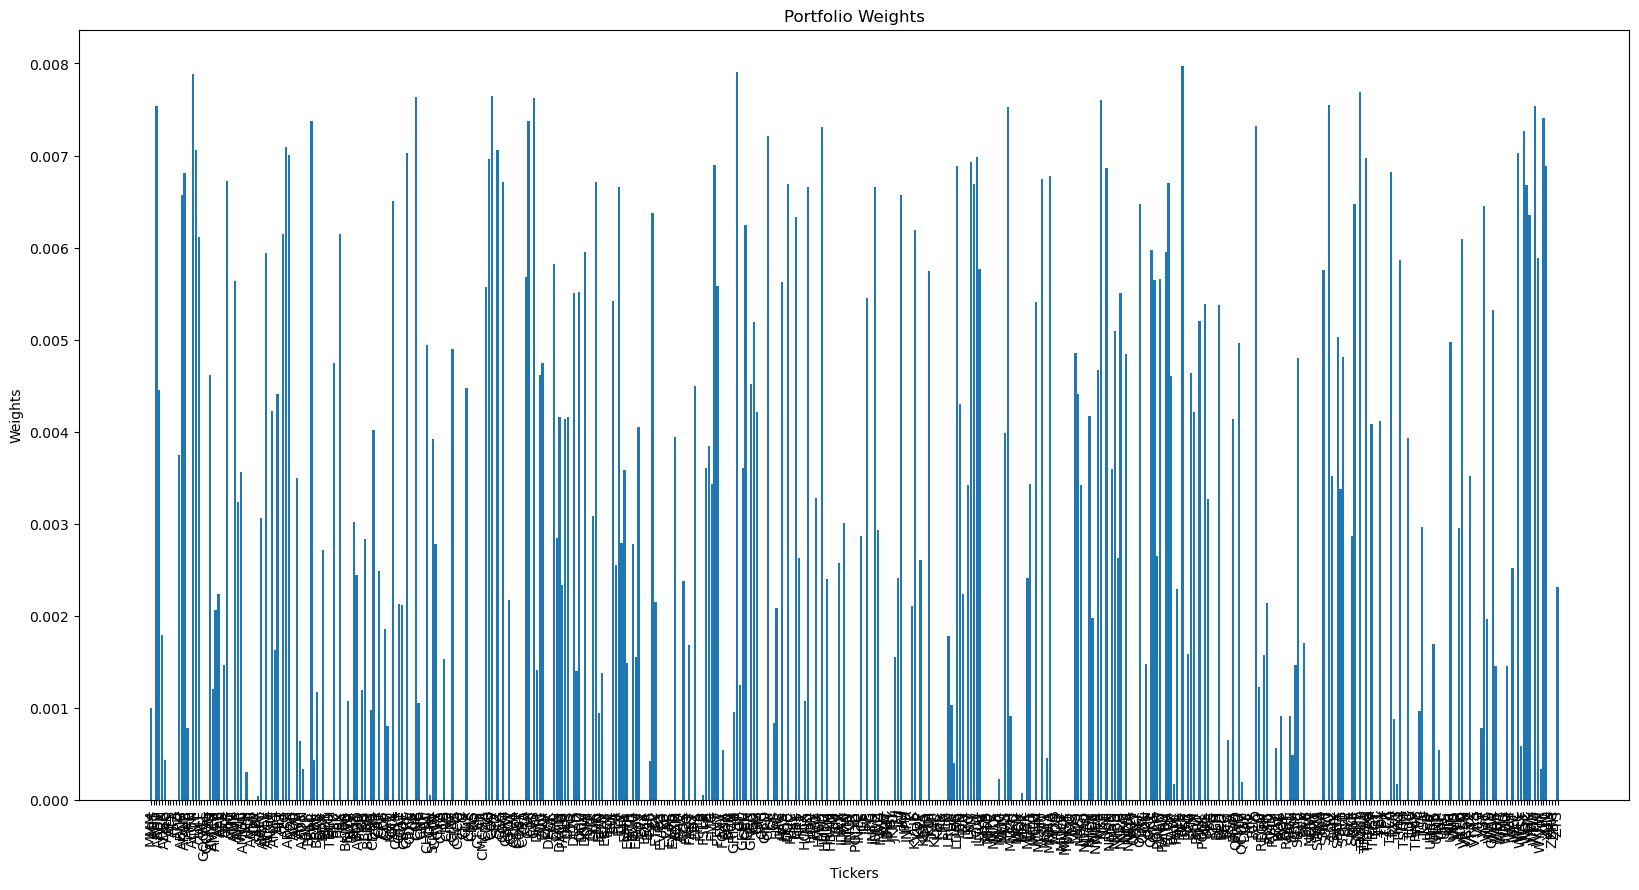

In [33]:
import matplotlib.pyplot as plt

# Assuming optimal_solution and successful_tickers are defined
weights = optimal_solution
tickers = successful_tickers

# Create a bar chart
plt.figure(figsize=(20,10))
plt.bar(tickers, weights)
plt.xlabel('Tickers')
plt.ylabel('Weights')
plt.title('Portfolio Weights')
plt.xticks(rotation=90)  # Rotate the x-axis labels for readability
plt.show()